## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [140]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [141]:
import pandas as pd
import re
from pathlib import Path
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text, geom_line, labs, scale_color_manual, coord_cartesian, geom_errorbar
import shap
from IPython.display import display
import matplotlib.pyplot as plt

In [142]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [143]:
PROJECT_ROOT = Path().resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data"

data_set = pd.read_feather(DATA_DIR / "financials_against_return.feather")

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [144]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [145]:
data_set.shape

(170483, 145)

Create the target:

In [146]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [147]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [148]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [149]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [150]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set, test_set, params):
    columns_to_remove = get_columns_to_remove()
    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    eval_result = {}

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        feval=[top_wt_performance],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)]
    )
    return model, eval_result, X_train, X_test

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [151]:
def run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, params, include_nulls_in_test=False):
    global train_set, test_set
    train_set, test_set = split_train_test_by_period(data_set, execution_date, include_nulls_in_test=include_nulls_in_test)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model, X_train, X_test = None, None, None

    if train_size > 0 and test_size > 0:
        model, evals_result, X_train, X_test = train_model(train_set, test_set, params)

        test_set['prob'] = model.predict(X_test)
        predicted_tickers = test_set.sort_values('prob', ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[(execution_date)] = evals_result
        all_models[(execution_date)] = model
        all_predicted_tickers_list.append(predicted_tickers)
    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test

execution_dates = np.sort( data_set['execution_date'].unique() )


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [154]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

params = {
    'n_estimators': n_trees,
}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,params,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [155]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [156]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [157]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


And this are the results:

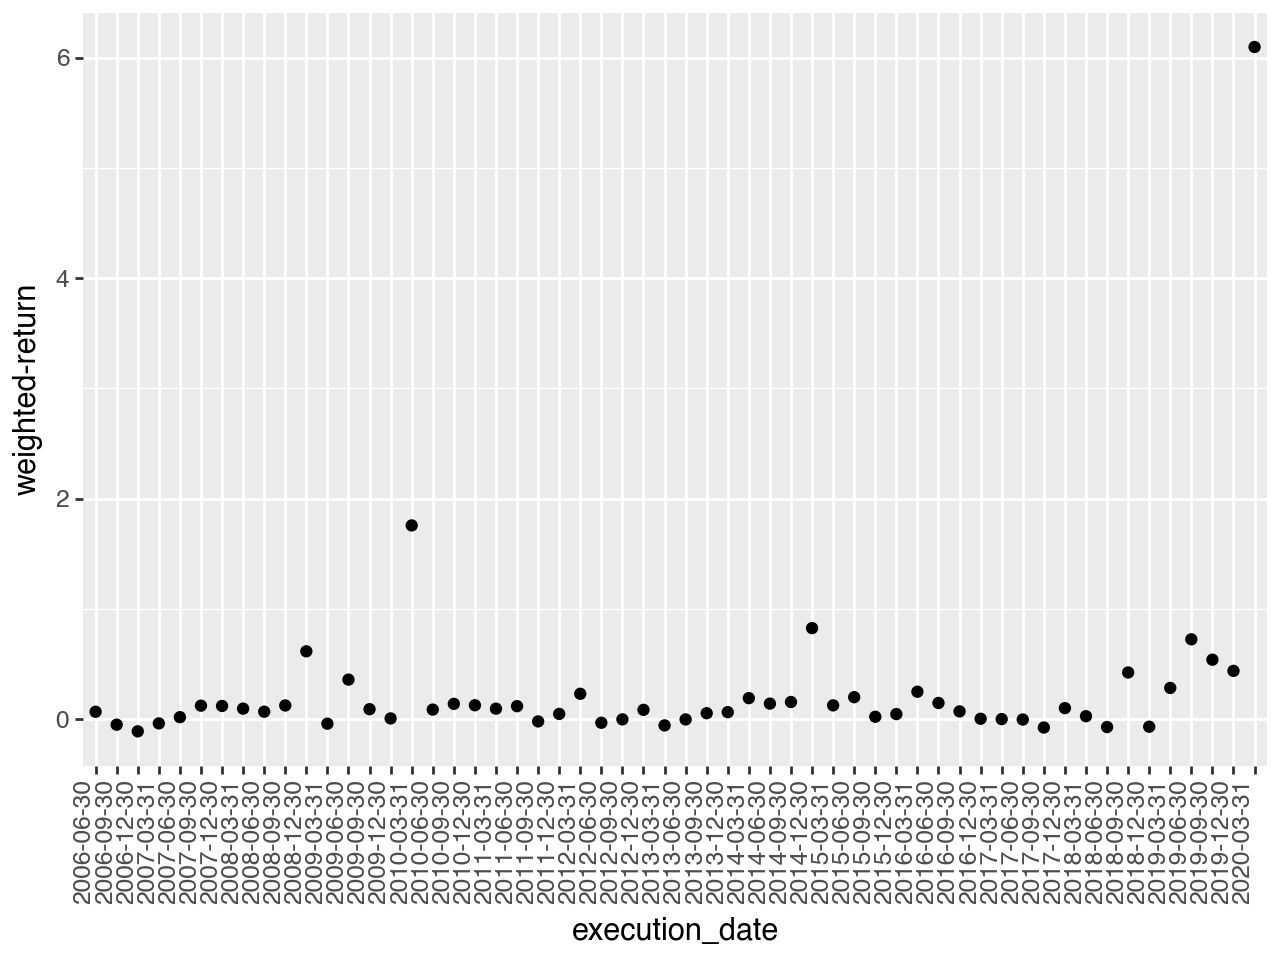

In [158]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



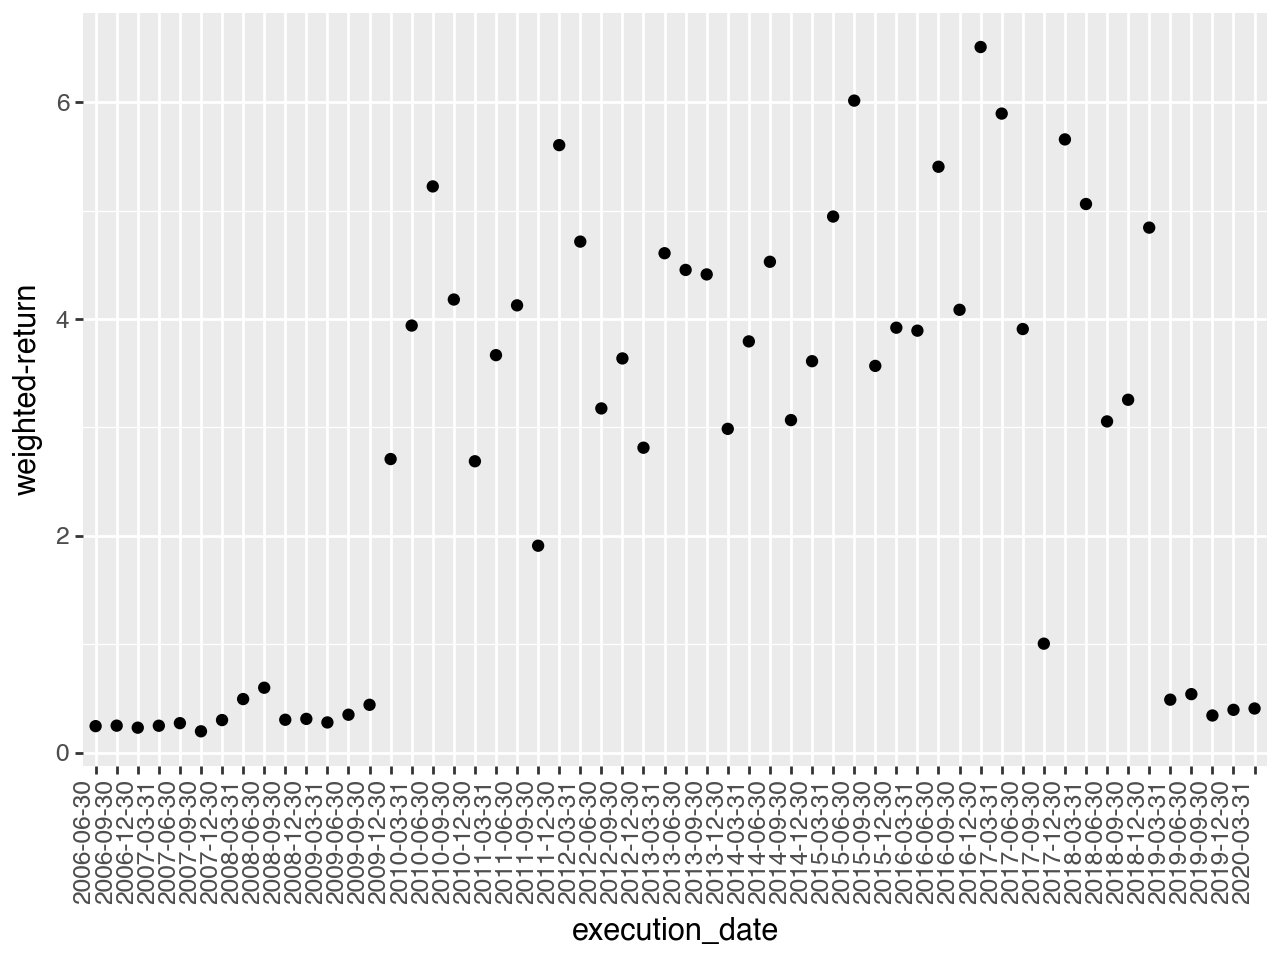

In [159]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [160]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


In [161]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

## Baseline model

In [162]:
def compute_baseline_top5(all_tickers_df, top_n=5, ret_col="stock_change_div_365"):
    """
    Create baseline DataFrame with the average return of the top N tickers by market cap for each execution date.
    """

    df = all_tickers_df.copy()
    df = df.sort_values(["execution_date", "Market_cap"], ascending=False)
    df["rank"] = df.groupby("execution_date").cumcount()
    df_top = df[df["rank"] < top_n].copy()

    baseline = (
        df_top.groupby("execution_date")[ret_col]
        .mean()
        .reset_index()
        .rename(columns={ret_col: f"baseline_top{top_n}_mktcap"})
    )

    return baseline


def plot_model_vs_baseline(merged_df, baseline_col, model_col="model_weighted_return",
                           zoom_ylim=(-5, 5), zoom=True):
    """
    Plot model vs baseline performance over time.
    """

    plot_long = merged_df.melt(
        id_vars="execution_date",
        value_vars=[model_col, baseline_col],
        var_name="strategy",
        value_name="weighted_return"
    )

    base_plot = (
        ggplot(plot_long, aes("execution_date", "weighted_return", color="strategy"))
        + geom_line()
        + geom_point(size=1.5)
        + labs(
            x="Execution date",
            y="Weighted return",
            title=f"Modelo vs {baseline_col}"
        )
        + theme(axis_text_x=element_text(angle=90))
        + scale_color_manual(values={
            model_col: "steelblue",
            baseline_col: "orange"
        })
    )

    if zoom:
        base_plot += coord_cartesian(ylim=zoom_ylim)

    return base_plot


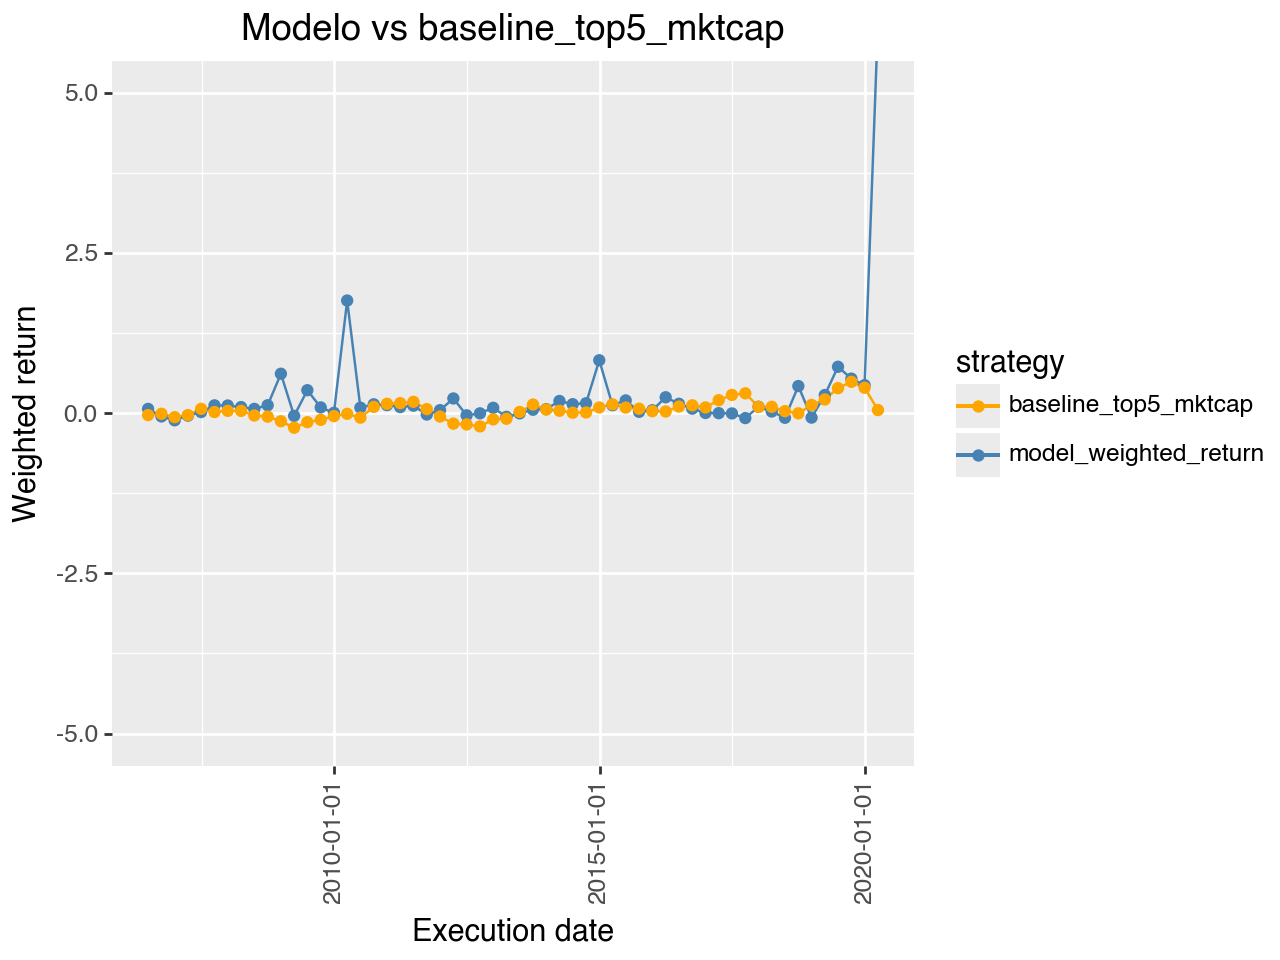

In [163]:
baseline_df = compute_baseline_top5(
    all_tickers_df=data_set,
    top_n=5,
    ret_col="diff_ch_sp500"
)

model_df = (
    test_results_final_tree[["execution_date", "weighted-return"]]
    .rename(columns={"weighted-return": "model_weighted_return"})
)

model_df["execution_date"] = pd.to_datetime(model_df["execution_date"])
baseline_df["execution_date"] = pd.to_datetime(baseline_df["execution_date"])
merged = pd.merge(
        model_df,
        baseline_df,
        on="execution_date",
        how="left"
    ).sort_values("execution_date")

plot = plot_model_vs_baseline(
    merged_df=merged,
    baseline_col="baseline_top5_mktcap",
    model_col="model_weighted_return",
    zoom_ylim=(-5, 5),
    zoom=True
)

plot


In [165]:
print(f"Given model mean metric: {merged['model_weighted_return'].mean()}")
print(f"Baseline model mean metric: {merged['baseline_top5_mktcap'].mean()}")

Given model mean metric: 0.261664439106911
Baseline model mean metric: 0.048940212315071584


The baseline model appears to be more stable, however our model improves it in general, adding more risk.

## Is the model learning and generalizing?

In [167]:
print(train_results)

          l2  weighted-return  n_trees execution_date n_trees_cat
0   0.232518         0.467174        0     2006-06-30           0
1   0.223455         0.394434        1     2006-06-30           1
2   0.214027         0.218716        2     2006-06-30           2
3   0.205538         0.259206        3     2006-06-30           3
4   0.197838         0.249536        4     2006-06-30           4
..       ...              ...      ...            ...         ...
35  0.216018         0.475196       35     2020-03-31          35
36  0.215658         0.475196       36     2020-03-31          36
37  0.215284         0.476650       37     2020-03-31          37
38  0.214937         0.483051       38     2020-03-31          38
39  0.214649         0.406675       39     2020-03-31          39

[2240 rows x 5 columns]


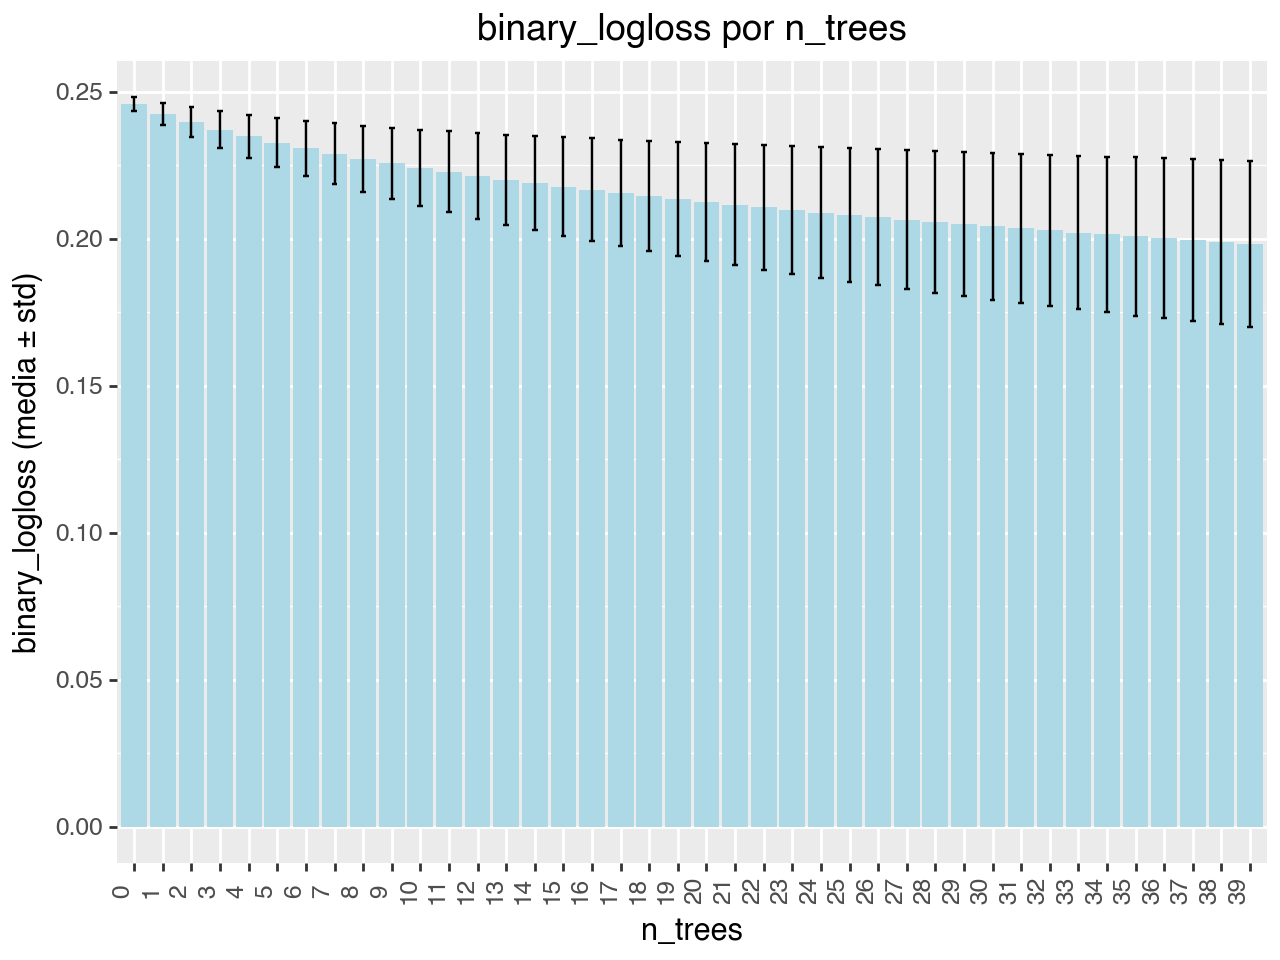

In [169]:
train_results["n_trees_cat"] = pd.Categorical(train_results["n_trees"],
                                             categories=sorted(train_results["n_trees"].unique()))

stats = train_results.groupby("n_trees_cat")["l2"].agg(["mean", "std"]).reset_index()
stats["ymin"] = stats["mean"] - stats["std"]
stats["ymax"] = stats["mean"] + stats["std"]

plot = (
    ggplot(stats, aes("n_trees_cat", "mean"))
    + geom_col(fill="lightblue")
    + geom_errorbar(aes(ymin="ymin", ymax="ymax"), width=0.2)
    + labs(x="n_trees", y="binary_logloss (media ± std)", title="binary_logloss por n_trees")
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)
plot

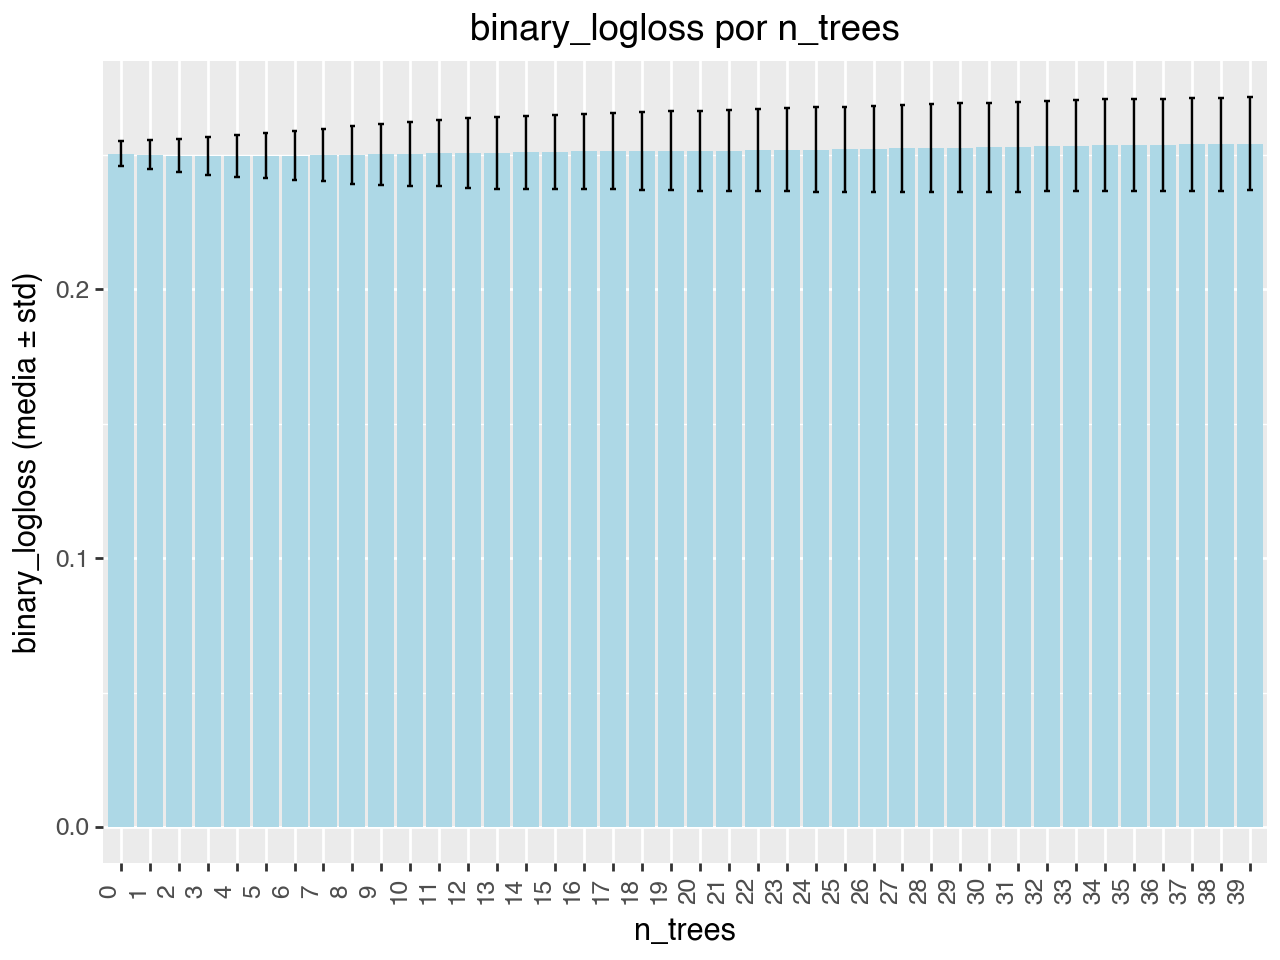

In [170]:
test_results["n_trees_cat"] = pd.Categorical(test_results["n_trees"],
                                             categories=sorted(test_results["n_trees"].unique()))

stats = test_results.groupby("n_trees_cat")["l2"].agg(["mean", "std"]).reset_index()
stats["ymin"] = stats["mean"] - stats["std"]
stats["ymax"] = stats["mean"] + stats["std"]

plot = (
    ggplot(stats, aes("n_trees_cat", "mean"))
    + geom_col(fill="lightblue")
    + geom_errorbar(aes(ymin="ymin", ymax="ymax"), width=0.2)
    + labs(x="n_trees", y="binary_logloss (media ± std)", title="binary_logloss por n_trees")
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)
plot

This indicates that while the model's binary logloss improves steadily on the training set as the number of trees increases as the curve is decreasing, the logloss on the test set remains almost constant. This pattern suggests possible overfitting: the model fits the training data better with more trees, but does not generalize to the test data.

### Retrain the model

We try with different hyperparameters in order to reduce the overfitting:
- `learning_rate`: Lowering it makes each boosting step smaller, which helps the model generalize better.
- `n_estimators`: Selecting an optimal number of trees prevents the model from growing too complex, as too many trees can lead to overfitting .
- `num_leaves`: Limiting the number of leaves per tree restricts the complexity of each individual tree, ensuring the model captures robust patterns rather than noise.

In [171]:
params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "n_estimators": 25,
    "learning_rate": 0.01,
    "num_leaves": 30,
    "objective": "binary",
    "metric": "binary_logloss"
}
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(
        execution_date, all_results, all_predicted_tickers_list, all_models, params, False)

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30

In [172]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

In [174]:
print(f"Hyperparametrized model mean metric: {merged['model_weighted_return'].mean()}")

Hyperparametrized model mean metric: 0.261664439106911


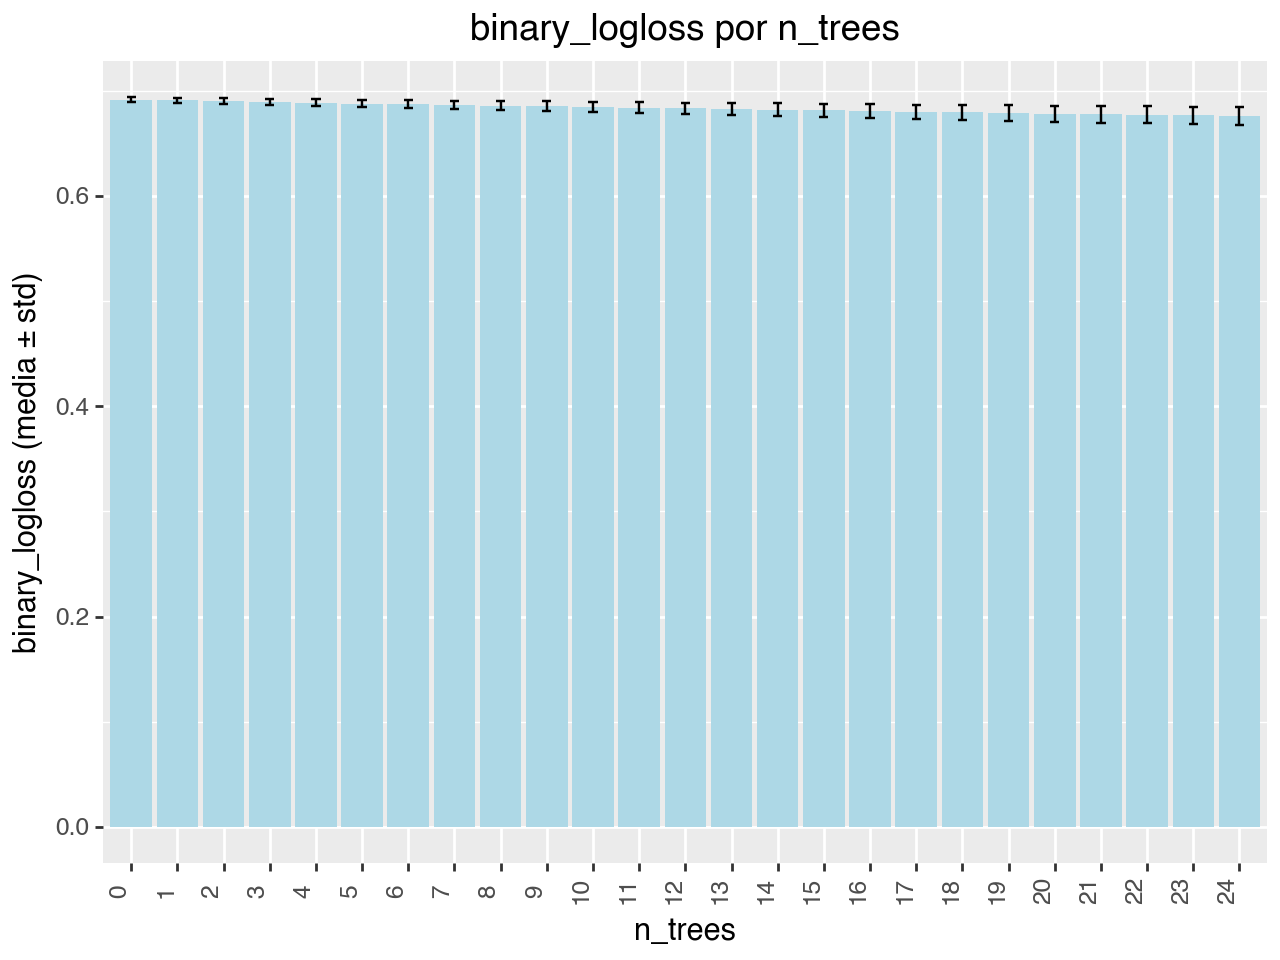

In [175]:
train_results["n_trees_cat"] = pd.Categorical(train_results["n_trees"],
                                             categories=sorted(train_results["n_trees"].unique()))

stats = train_results.groupby("n_trees_cat")["binary_logloss"].agg(["mean", "std"]).reset_index()
stats["ymin"] = stats["mean"] - stats["std"]
stats["ymax"] = stats["mean"] + stats["std"]

plot = (
    ggplot(stats, aes("n_trees_cat", "mean"))
    + geom_col(fill="lightblue")
    + geom_errorbar(aes(ymin="ymin", ymax="ymax"), width=0.2)
    + labs(x="n_trees", y="binary_logloss (media ± std)", title="binary_logloss por n_trees")
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)
plot

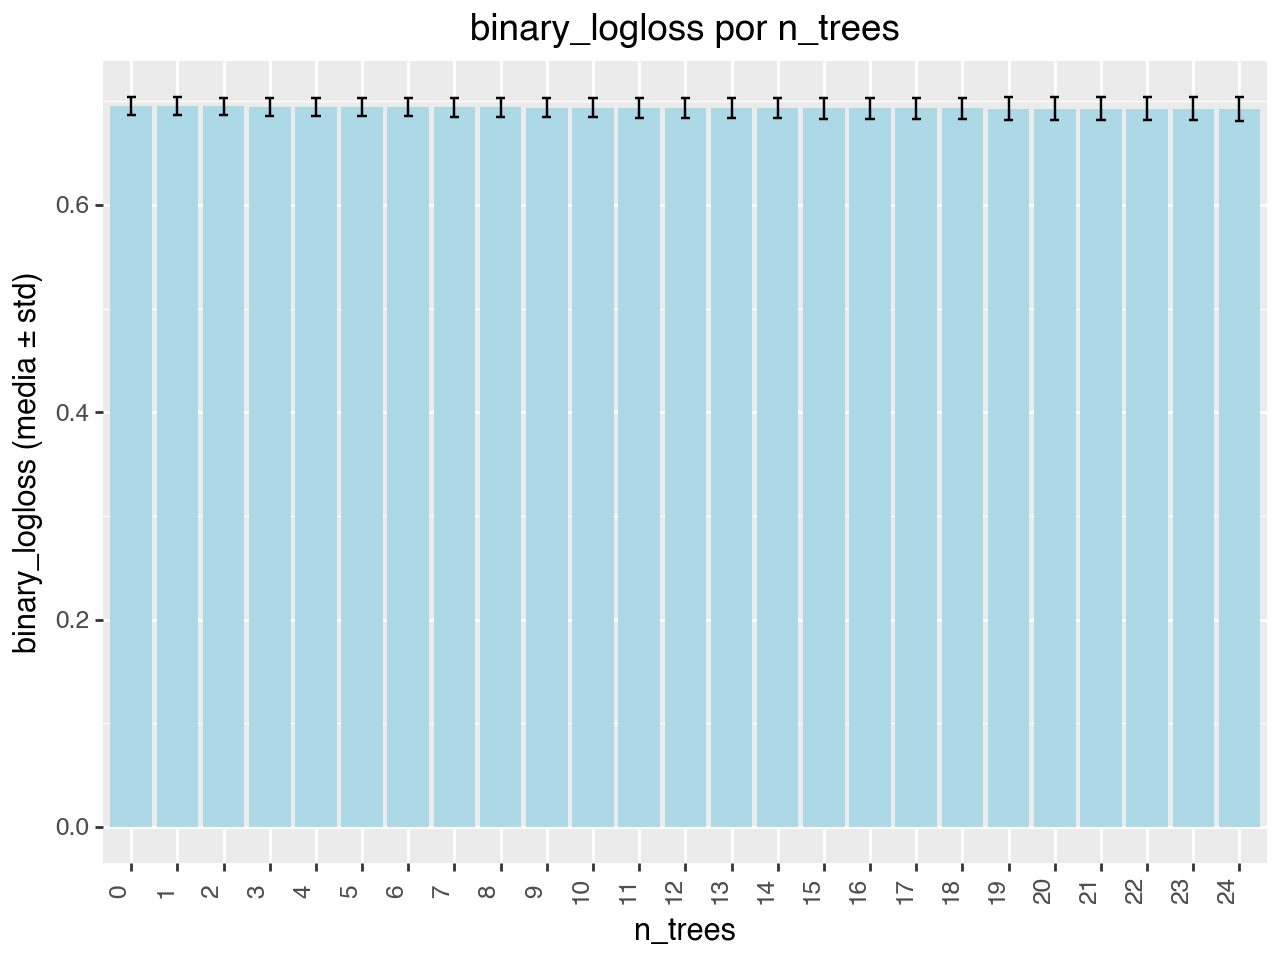

In [176]:
test_results["n_trees_cat"] = pd.Categorical(test_results["n_trees"],
                                             categories=sorted(test_results["n_trees"].unique()))

stats = test_results.groupby("n_trees_cat")["binary_logloss"].agg(["mean", "std"]).reset_index()
stats["ymin"] = stats["mean"] - stats["std"]
stats["ymax"] = stats["mean"] + stats["std"]

plot = (
    ggplot(stats, aes("n_trees_cat", "mean"))
    + geom_col(fill="lightblue")
    + geom_errorbar(aes(ymin="ymin", ymax="ymax"), width=0.2)
    + labs(x="n_trees", y="binary_logloss (media ± std)", title="binary_logloss por n_trees")
    + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1))
)
plot

Now we can appreciate a little improvement, since our data in the plot is decreasing.

## Feature importance

Let's start by looking at the importance of each feature in the models.

We can use the function to plot it for each model.

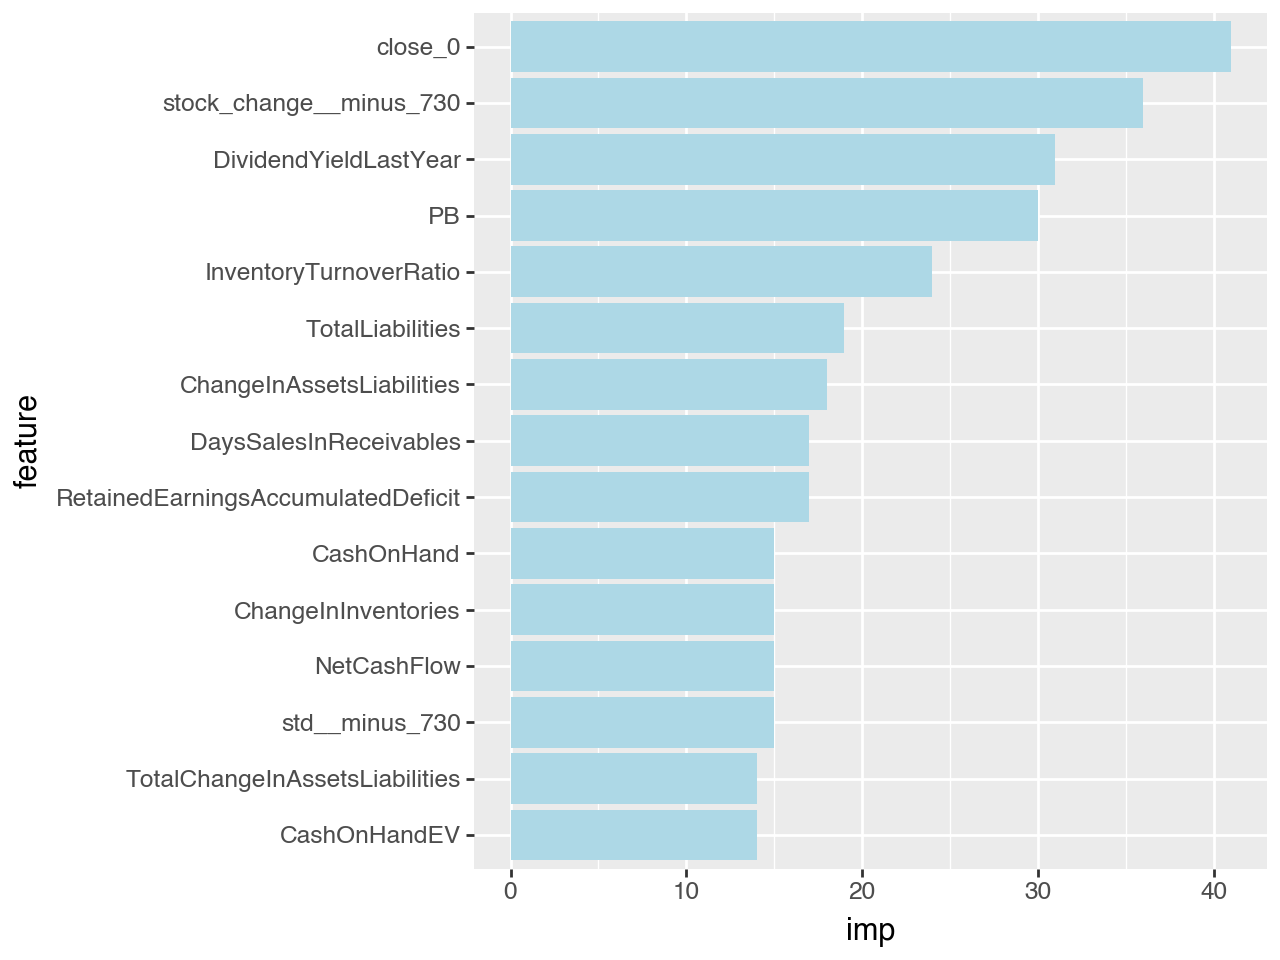

In [177]:
fecha_valida = sorted(all_models.keys())[0]
modelo = all_models[fecha_valida]

draw_feature_importance(modelo)

We can define a function that plots the average feature importance across all models, allowing us to observe how feature relevance varies.

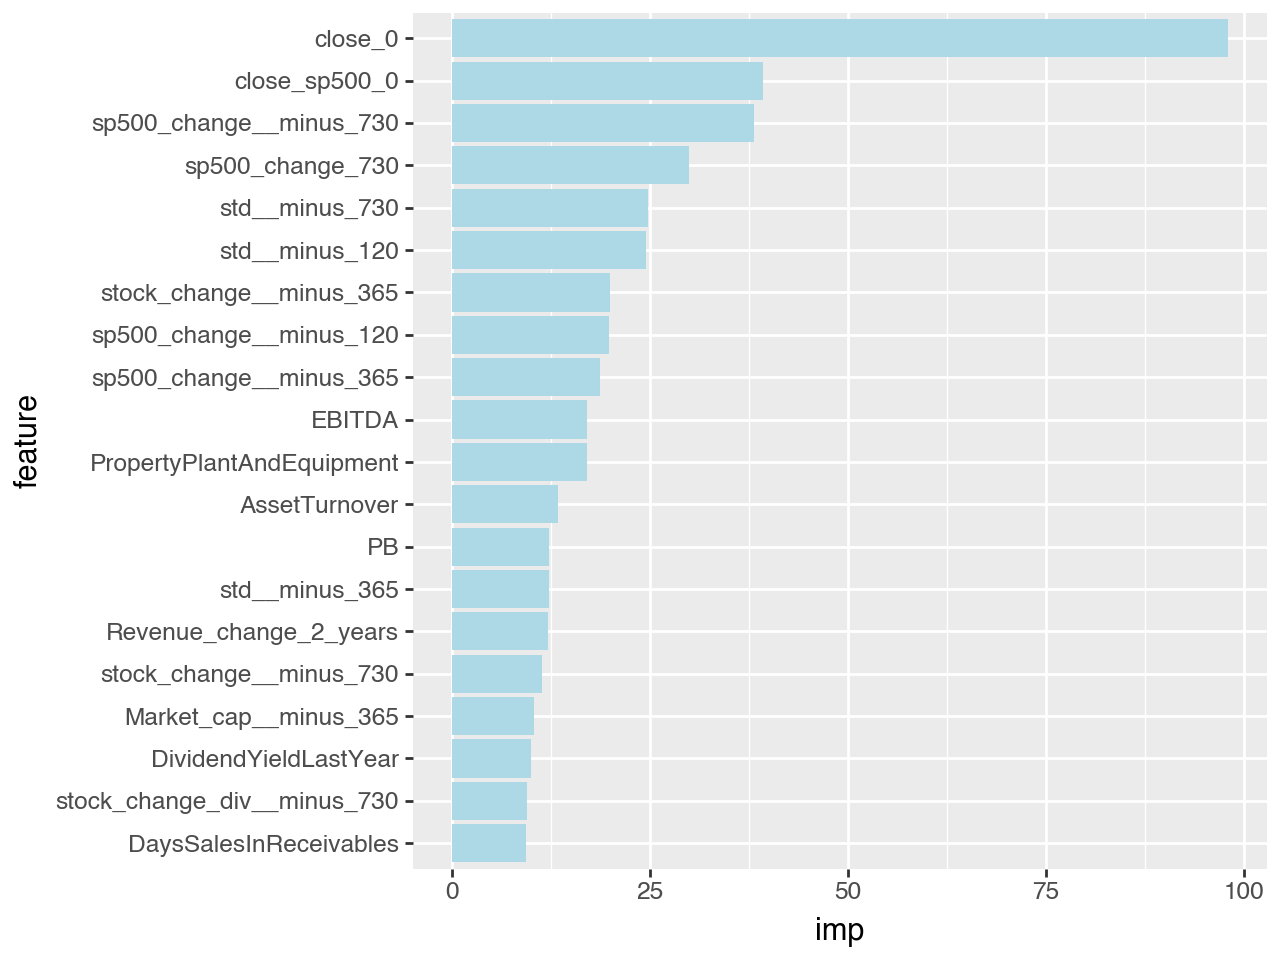

In [178]:
importance_sum = None

for model in all_models.values():
    fi = model.feature_importance()
    fn = model.feature_name()
    df_tmp = pd.DataFrame({"feature":fn, "imp":fi})
    if importance_sum is None:
        importance_sum = df_tmp
    else:
        importance_sum['imp'] += df_tmp['imp']
importance_sum['imp'] = importance_sum['imp'] / len(all_models)

def draw_feature_importance_from_df(feature_importance, top=15):
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot

draw_feature_importance_from_df(importance_sum, top=20)

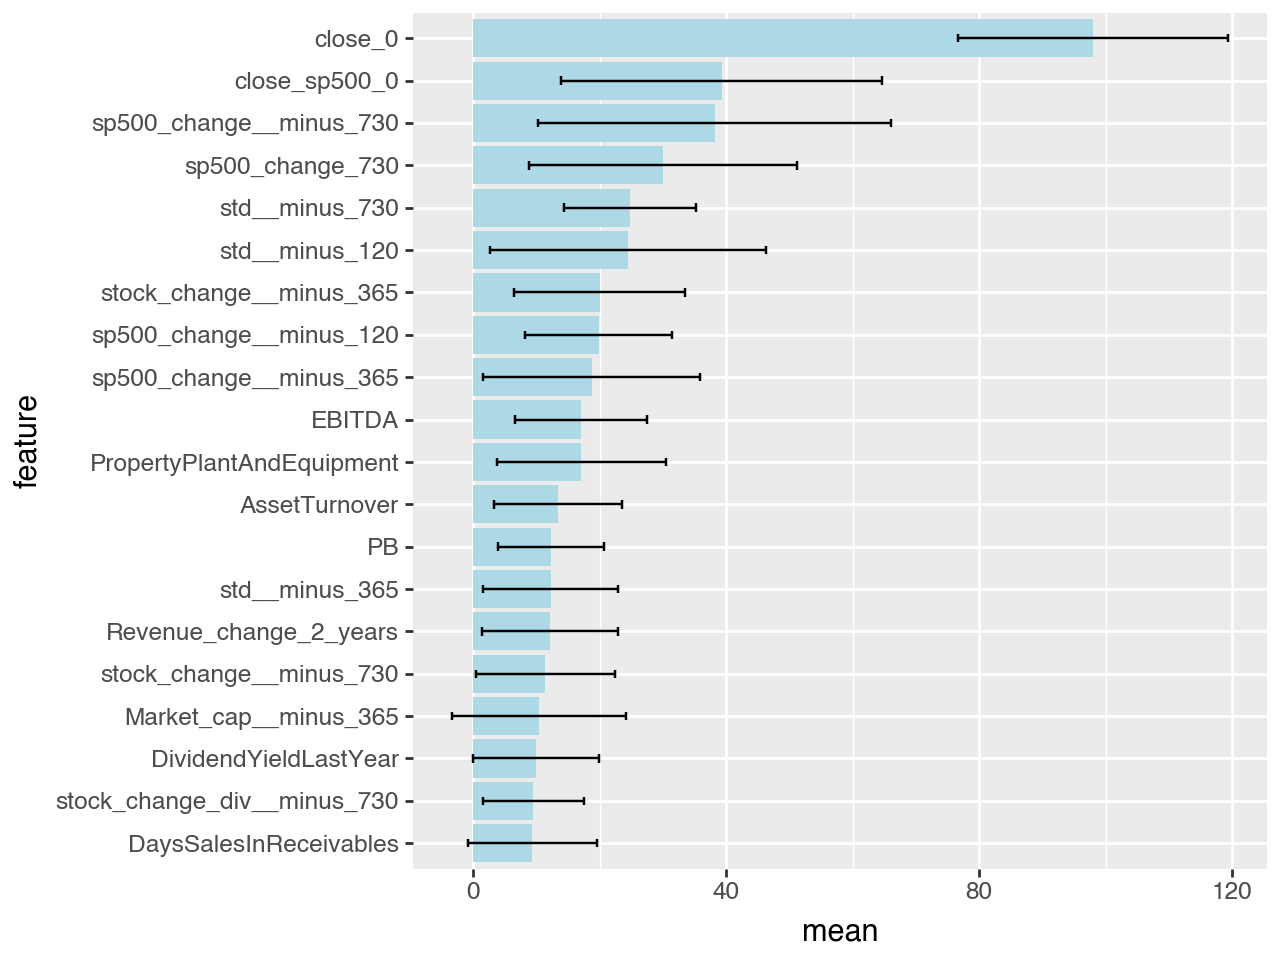

In [179]:
import pandas as pd
from plotnine import ggplot, aes, geom_col, coord_flip, scale_x_discrete, geom_errorbar

dfs = []
for model in all_models.values():
    fi = model.feature_importance()
    fn = model.feature_name()
    df_tmp = pd.DataFrame({"feature":fn, "imp":fi})
    dfs.append(df_tmp)

all_importances = pd.concat(dfs)
stats = all_importances.groupby('feature')['imp'].agg(['mean', 'var']).reset_index()
stats_top = stats.nlargest(20, 'mean').sort_values('mean')

plot = (
    ggplot(stats_top, aes(x='feature', y='mean'))
    + geom_col(fill='lightblue')
    + geom_errorbar(aes(ymin=stats_top['mean']-stats_top['var']**0.5, ymax=stats_top['mean']+stats_top['var']**0.5), width=0.2)
    + coord_flip()
    + scale_x_discrete(limits=stats_top['feature'])
)
plot


Generating SHAP for execution_date = 2020-03-31T00:00:00.000000000


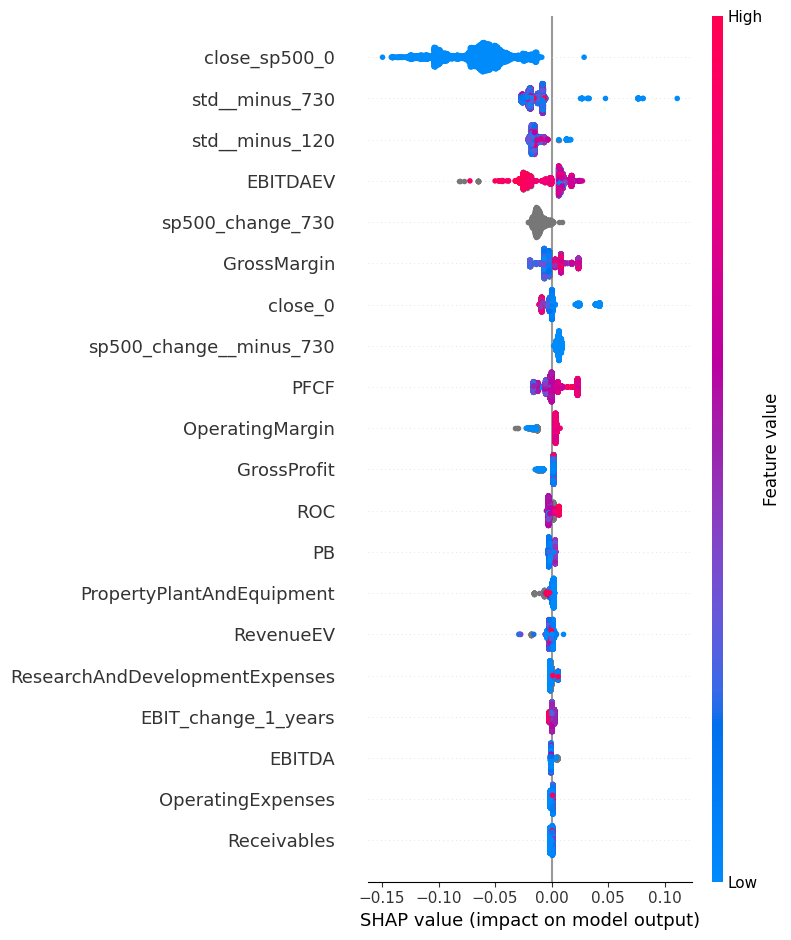

In [180]:
def compute_and_plot_shap_for_date(execution_date, model=None, preds_df=None, n_instances=5):
    """
    Calculate SHAP values for the test set associated with `execution_date` and plot:
    - Summary plot of global feature importance for that test set.
    - Waterfall / force plot for the top n instances (ordered by predicted probability).
    """
    if preds_df is None:
        preds_df = all_predicted_tickers
    if model is None:
        model = all_models[execution_date]
    
    test_df = preds_df.loc[preds_df["execution_date"] == execution_date].copy()
    if test_df.empty:
        raise ValueError(f"No rows for execution_date={execution_date}")

    cols_to_remove = get_columns_to_remove() + ["prob", "execution_date"]
    X = test_df.drop(columns=cols_to_remove, errors="ignore")
    model_fn = model.feature_name()
    known_cols = [c for c in model_fn if c in X.columns]
    X = X[known_cols]  # same order as model expects

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # select SHAP values for positive class if applicable
    if isinstance(shap_values, list) and len(shap_values) == 2:
        sv = shap_values[1]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        sv = shap_values[1]
    else:
        sv = shap_values

    shap.initjs()

    # summary plot (importancia global para este test set)
    plt.figure(figsize=(16, 10))
    shap.summary_plot(sv, X, show=False)
    plt.tight_layout()
    display(plt.gcf())
    plt.clf()

if len(all_models) > 0:
    fecha_ejemplo = sorted(all_models.keys())[-1]
    print("Generating SHAP for execution_date =", fecha_ejemplo)
    compute_and_plot_shap_for_date(fecha_ejemplo, n_instances=5)
else:
    print("There are no models to explain with SHAP.")

The SHAP summary plot shows which features are most influential in the model's predictions.

In this case, variables such as `close_sp500_0`, long-term and short-term volatility (`std__minus_730`, `std__minus_120`), and several financial ratios like `EBITDAEV` and `GrossMargin` have the highest impact on model output. We can see that both technical and fundamental features are important for the model.